Среда обладает следующими свойствами:

- Пространство действий - это множество возможных действий, которые мы можем выполнять на каждом шаге моделирования
- Пространство наблюдений - это пространство наблюдений, которые мы можем сделать

In [ ]:
import gym

env = gym.make("CartPole-v1")

print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")

Посмотрим, как работает симуляция. Следующий цикл запускает симуляцию до тех пор, пока env.step не вернет флаг завершения done. Мы будем выбирать действия случайным образом, используя env.action_space.sample(), поэтому эксперимент, скорее всего, закончится очень быстро (среда CartPole завершает работу, когда скорость CartPole, его положение или угол выходят за определенные пределы).

Симуляция откроется в новом окне. Вы можете запустить код несколько раз и посмотреть, как он себя ведет.

In [5]:
env.reset()

done = False
total_reward = 0
while not done:
   env.render()
   obs, rew, done, info,_ = env.step(env.action_space.sample())
   total_reward += rew
   print(f"{obs} -> {rew}")
print(f"Total reward: {total_reward}")

[-0.00098678  0.20502952 -0.01614757 -0.33474112] -> 1.0
[ 0.00311381  0.4003775  -0.02284239 -0.6324721 ] -> 1.0
[ 0.01112136  0.20558158 -0.03549184 -0.34706947] -> 1.0
[ 0.015233    0.01098196 -0.04243322 -0.06578628] -> 1.0
[ 0.01545263  0.20668578 -0.04374895 -0.3715494 ] -> 1.0
[ 0.01958635  0.01221179 -0.05117994 -0.09297561] -> 1.0
[ 0.01983059  0.20802853 -0.05303945 -0.40135643] -> 1.0
[ 0.02399116  0.4038611  -0.06106658 -0.7102785 ] -> 1.0
[ 0.03206838  0.20963566 -0.07527215 -0.43742582] -> 1.0
[ 0.03626109  0.01565538 -0.08402067 -0.16938843] -> 1.0
[ 0.0365742   0.21187317 -0.08740844 -0.48734987] -> 1.0
[ 0.04081166  0.01808625 -0.09715543 -0.22344457] -> 1.0
[ 0.04117339  0.21445288 -0.10162432 -0.54512423] -> 1.0
[ 0.04546244  0.41084495 -0.1125268  -0.8680186 ] -> 1.0
[ 0.05367934  0.6073033  -0.12988718 -1.1938555 ] -> 1.0
[ 0.06582541  0.80384576 -0.1537643  -1.5242654 ] -> 1.0
[ 0.08190233  0.61087847 -0.1842496  -1.2832583 ] -> 1.0
[ 0.09411989  0.41851765 -0.209

Наблюдения содержат 4 числа. Это:

- Положение тележки
- Скорость тележки
- Угол наклона полюса
- Скорость вращения полюса
reward - вознаграждение, которое мы получаем на каждом шаге. Видно, что в среде CartPole за каждый шаг моделирования начисляется 1 очко, и целью является максимизация общего вознаграждения, т.е. времени, в течение которого CartPole сможет балансировать без падения.

В процессе обучения с подкреплением наша цель состоит в обучении такой политики $\pi$ которая для каждого состояния $s$ подскажет нам, какое действие $a$ предпринять, так что по сути мы ищем $a = \pi(s)$
.

Если мы хотим получить вероятностное решение, то можно представить политику как возвращающую набор вероятностей для каждого действия, т.е. $\pi(a|s)$ будет означать вероятность того, что мы должны предпринять действие $a$ в состоянии $s$
.

В простейшем алгоритме RL, называемом Policy Gradient, мы будем обучать нейронную сеть предсказывать следующее действие.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch

num_inputs = 4
num_actions = 2

model = torch.nn.Sequential(
    torch.nn.Linear(num_inputs, 128, bias=False, dtype=torch.float32),
    torch.nn.ReLU(),
    torch.nn.Linear(128, num_actions, bias = False, dtype=torch.float32),
    torch.nn.Softmax(dim=1)
)

Мы будем обучать сеть, проводя множество экспериментов и обновляя сеть после каждого эксперимента. Определим функцию, которая будет запускать эксперимент и возвращать результаты (так называемую трассу) - все состояния, действия (и их рекомендуемые вероятности) и вознаграждения:

In [16]:
def run_episode(max_steps_per_episode = 10000,render=False):    
    states, actions, probs, rewards = [],[],[],[]
    state = env.reset()
    state = state[0]
    for _ in range(max_steps_per_episode):
        if render:
            env.render()
            
        action_probs = model(torch.from_numpy(np.expand_dims(state,0)))[0]
        action = np.random.choice(num_actions, p=np.squeeze(action_probs.detach().numpy()))
        nstate, reward, done, info,_ = env.step(action)
        if done:
            break
        states.append(state)
        actions.append(action)
        probs.append(action_probs.detach().numpy())
        rewards.append(reward)
        state = nstate
    return np.vstack(states), np.vstack(actions), np.vstack(probs), np.vstack(rewards)

Мы можем запустить один эпизод с необученной сетью и заметить, что общее вознаграждение (оно же длина эпизода) очень мало:

In [17]:
s, a, p, r = run_episode()
print(f"Total reward: {np.sum(r)}")

Total reward: 13.0


Одним из сложных аспектов Policy Gradient алгоритма является использование дисконтированных вознаграждений. Идея заключается в том, что мы вычисляем вектор суммарных вознаграждений на каждом шаге игры и в ходе этого процесса дисконтируем ранние вознаграждения с помощью некоторого коэффициента . Полученный вектор мы также нормализуем, поскольку будем использовать его в качестве веса, влияющего на обучение:

In [18]:
eps = 0.0001

def discounted_rewards(rewards,gamma=0.99,normalize=True):
    ret = []
    s = 0
    for r in rewards[::-1]:
        s = r + gamma * s
        ret.insert(0, s)
    if normalize:
        ret = (ret-np.mean(ret))/(np.std(ret)+eps)
    return ret

Теперь приступим к собственно тренировке! Мы проведем 300 эпизодов, и в каждом эпизоде мы будем делать следующее:

1. Запустим эксперимент и соберем трассу
2. Вычислим разницу (градиенты) между выполненными действиями и предсказанными вероятностями. Чем меньше разница, тем больше уверенности, что мы совершили правильное действие.
3. Вычислим дисконтированные вознаграждения и умножить градиенты на дисконтированные вознаграждения - это позволит убедиться в том, что шаги с большим вознаграждением окажут большее влияние на конечный результат, чем шаги с меньшим вознаграждением.
4. Ожидаемые целевые действия для нашей нейронной сети будут частично взяты из предсказанных вероятностей во время выполнения, а частично из рассчитанных градиентов. Для определения степени учета градиентов и вознаграждений мы будем использовать параметр alpha - это называется скоростью обучения алгоритма подкрепления.
5. Наконец, мы обучаем нашу сеть на состояниях и ожидаемых действиях и повторяем процесс

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train_on_batch(x, y):
    x = torch.from_numpy(x)
    y = torch.from_numpy(y)
    optimizer.zero_grad()
    predictions = model(x)
    loss = -torch.mean(torch.log(predictions) * y)
    loss.backward()
    optimizer.step()
    return loss

0 -> 21.0
100 -> 664.0
200 -> 10000.0


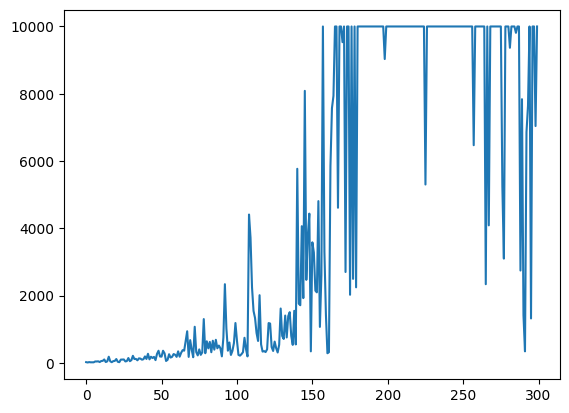

In [20]:
alpha = 1e-4

history = []
for epoch in range(300):
    states, actions, probs, rewards = run_episode()
    one_hot_actions = np.eye(2)[actions.T][0]
    gradients = one_hot_actions-probs
    dr = discounted_rewards(rewards)
    gradients *= dr
    target = alpha*np.vstack([gradients])+probs
    train_on_batch(states,target)
    history.append(np.sum(rewards))
    if epoch%100==0:
        print(f"{epoch} -> {np.sum(rewards)}")

plt.plot(history)

Теперь запустим эпизод с рендерингом, чтобы увидеть результат:

In [23]:
_ = run_episode(render=True)